<a href="https://colab.research.google.com/github/kobejean/lanl-earthquake-prediction/blob/kernels%2Fdcnn-p-e2e-tf/dcnn_p_e2e_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m pip install dhooks

    100% |████████████████████████████████| 1.2MB 17.6MB/s 
    100% |████████████████████████████████| 61kB 21.3MB/s 
    100% |████████████████████████████████| 317kB 30.5MB/s 
    100% |████████████████████████████████| 256kB 24.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/06/96/0e/abb2ead42895b4736064f77c5e829e4dfff6e280e0add6a39c
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built dhooks idna-ssl
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
google-colab 0.0.1a1 has requirement requests~=2.18.0, but you'll have requests 2.20.1 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4


In [1]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in
# JAKE COMMENT!!!!!!!!!!!!!!!!!!!!!!

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from dhooks import Webhook, Embed, File
from io import BytesIO

import os
import sys
import glob
import random
import time

print("Imported!")

Imported!


In [2]:
model_name = 'dcnn-p-e2e-tf'
discord_webhook_url = 'https://discordapp.com/api/webhooks/541724267461476388/6RSn5xYXbr-bPy-nV1P4FuSLQJLQXx31xG76gCqva3UVnA2eavbKi4boZdKPHE24jjQq'  #@param {type:"string"}
total_size = 629_145_480
seg_size = 150_000
packet_size = 2**12 # data comes in bins of 2^12 contiguous rows (ADC with 12-bit resolution)

epochs = 1600 #16 * bins_per_seg
train_batch_size = 128 #@param {type:"integer"}
valid_batch_size = 128 #@param {type:"integer"}
test_batch_size = 128 #@param {type:"integer"}
predict_batch_size = 128 #@param {type:"integer"}

total_earthquakes = 16
valid_earthquakes = 2  #@param {type:"integer"}
test_earthquakes = 2  #@param {type:"integer"}
train_earthquakes = total_earthquakes - valid_earthquakes - test_earthquakes

packets = [1381-2, 10847-8, 13328-10, 8324-7, 11931-9, 7571-6, 6635-5, 15139-12, 7431-6, 9058-7, 10740-8, 10362-9, 8298-6, 8051-6, 13865-11, 8891-7]#, 1748-2]

experiments = [
    {
        'experiment_name': 'x9',
        'description': 'experiment 9 - mse ',
        'learning_rate': 0.00125,
        'dilation_rates': [1, 4, 16, 64, 256, 1024] * 2 ,
        'kernel_sizes': [4] * 6 * 2,
        'filter_width': 32,
        'random_seed': 42,
        'max_epochs': 120, 
        'epochs_per_validation': 10,
        'early_stopping_epsilon': 2.0,
        'use_last_mae_loss': False,
        'padding': 'causal',
        'cross_validation_sets': [5,4,3,2,1,0,6],
        'reshuffle_training_data': False
    },
]

### Google Cloud Storage Auth ###
import json
import os
import pprint
import re
import time
import tensorflow as tf


use_tpu = True #@param {type:"boolean"}
bucket = 'lanl-earthquake-prediction' #@param {type:"string"}

assert bucket, 'Must specify an existing GCS bucket name'
print('Using bucket: {}'.format(bucket))

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

DATASET_PATH = 'gs://{}/{}'.format(bucket, 'datasets/')
print('Using dataset path: {}'.format(DATASET_PATH))

from google.colab import auth
auth.authenticate_user()

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
  
  # Upload credentials to TPU.
  with tf.Session(TF_MASTER) as sess:    
    with open('/content/adc.json', 'r') as f:
      auth_info = json.load(f)
    tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.
else:
  TF_MASTER=''

with tf.Session(TF_MASTER) as session:
  pprint.pprint(session.list_devices())
  
### Google Cloud Storage Auth End ###

def experimentsSummary(params):
  lines = []
  lines.append("Experiment")
  lines.append("---------------------------")
  lines.append("")
  lines.append("key | value")
  lines.append("------------ | ------------")
  lines.append("experiment_name | " + str(params['experiment_name']))
  lines.append("description | " + str(params['description']))
  lines.append("learning_rate | " + str(params['learning_rate']))
  lines.append("dilation_rates | " + str(params['dilation_rates']))
  lines.append("kernel_sizes | " + str(params['kernel_sizes']))
  lines.append("filter_width | " + str(params['filter_width']))
  lines.append("random_seed | " + str(params['random_seed']))
  lines.append("max_epochs | " + str(params['max_epochs']))
  lines.append("epochs_per_validation | " + str(params['epochs_per_validation']))
  lines.append("early_stopping_epsilon | " + str(params['early_stopping_epsilon']))
  lines.append("use_last_mae_loss | " + str(params['use_last_mae_loss']))
  lines.append("padding | " + str(params['padding']))
  lines.append("cross_validation_sets | " + str(params['cross_validation_sets']))
  lines.append("reshuffle_training_data | " + str(params['reshuffle_training_data']))
#   lines.append("---------------------------")
  return '\n'.join(str(x) for x in lines) 

for params in experiments:
  print(experimentsSummary(params))

Using bucket: lanl-earthquake-prediction
Using dataset path: gs://lanl-earthquake-prediction/datasets/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 1982939555876360419),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6066849264320339470),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11758908707406300435),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 11491515485667696472),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 10457308234539209914),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16380127534178915698),
 _DeviceAttributes(/jo

In [3]:
#@title Data and Model
from tensorflow.data import TFRecordDataset, Dataset

def parse_function(example_proto):
    default_value = [0] * packet_size
    data = {"acoustic_data": tf.FixedLenFeature((packet_size, 1), tf.float32, default_value=default_value),
            "time_to_failure": tf.FixedLenFeature((packet_size), tf.float32, default_value=default_value)}
    parsed_data = tf.parse_single_example(example_proto, data)
    acoustic_data = parsed_data["acoustic_data"]
    time_to_failure = parsed_data["time_to_failure"]
    return acoustic_data, time_to_failure
  
def parse_predict_function(example_proto):
    default_value = [0] * packet_size
    data = {"acoustic_data": tf.FixedLenFeature((packet_size, 1), tf.float32, default_value=default_value)}
    parsed_data = tf.parse_single_example(example_proto, data)
    acoustic_data = parsed_data["acoustic_data"]
    return acoustic_data


def train_fn(params):
    print(params)
    batch_size = params['batch_size']
    train_batches = params['train_batches'] 
    train_tf_record_files = params['train_tf_record_files']
    random_seed = params['random_seed']
    reshuffle_training_data = params['reshuffle_training_data']
    epochs_per_validation = params['epochs_per_validation']
    files = Dataset.from_tensor_slices(train_tf_record_files)
    dataset = (TFRecordDataset(files, num_parallel_reads=4)
               .map(parse_function)
               .filter( lambda f, l : l[-1] > 0.35 )
               .shuffle(batch_size*train_batches, seed=random_seed, reshuffle_each_iteration=reshuffle_training_data)
               .batch(batch_size, drop_remainder=True)
               .prefetch(train_batches)
               .repeat()
              )
    return dataset.make_one_shot_iterator().get_next()
  
  
def valid_fn(params):
    print(params)
    valid_tf_record_files = params['valid_tf_record_files']
    valid_batches = params['valid_batches']
    batch_size = params['batch_size']
    files = Dataset.from_tensor_slices(valid_tf_record_files)
    dataset = (TFRecordDataset(files)
               .map(parse_function)
               .batch(batch_size, drop_remainder=True)
               .prefetch(valid_batches)
              )
    return dataset.make_one_shot_iterator().get_next()
  
def continuous_set_fn(params):
  print(params)
  tf_record_files = params['train_tf_record_files'] + params['valid_tf_record_files']
  batches = params['train_batches'] + params['valid_batches']
  batch_size = params['batch_size']
  files = Dataset.from_tensor_slices(tf_record_files)
  dataset = (TFRecordDataset(files)
             .map(parse_function)
             .batch(batch_size, drop_remainder=True)
             .prefetch(batches)
            )
  return dataset.make_one_shot_iterator().get_next()

def continuous_set_predict_fn(params):
  print(params)
  tf_record_files = params['train_tf_record_files'] + params['valid_tf_record_files']
  batches = params['train_batches'] + params['valid_batches']
  batch_size = params['batch_size']
  files = Dataset.from_tensor_slices(tf_record_files)
  dataset = (TFRecordDataset(files)
             .map(parse_predict_function)
             .batch(batch_size, drop_remainder=True)
             .prefetch(batches)
            )
  return dataset

# sess = tf.Session()
# features, labels = train_fn({'batch_size': train_batch_size})
# print(sess.run(features))
# print(sess.run(labels))
# features, labels = valid_fn({'batch_size': valid_batch_size})
# print(sess.run(features))
# print(sess.run(labels))

def mae(labels, predictions):
  return tf.metrics.mean(tf.abs(labels - predictions))

def last_mae(labels, predictions):
    return mae(labels[:,-1], predictions[:,-1])
  
def mid_mae(labels, predictions):
    return mae(labels[:,2047:2049], predictions[:,2047:2049])

def seq_mae(labels, predictions):
    # seq is 0.0375 secs long so on average we are predicting 0.01875 secs more than the last time step
    return mae(labels[:,-1], tf.reduce_mean(predictions, axis=1) - 4.5e-6) 
  
def metric_fn(labels, predictions):
  metrics = {
    'mae': mae(labels, predictions),
    'last_mae': last_mae(labels, predictions),
    'mid_mae': mid_mae(labels, predictions),
    'seq_mae': seq_mae(labels, predictions),
  }
#   tf.summary.scalar('mae', metrics['mae'][0])
#   tf.summary.scalar('last_mae', metrics['last_mae'][0])
#   tf.summary.scalar('seq_mae', metrics['seq_mae'][0])
  return metrics
  

def model_fn(features, labels, mode, params):
  filter_width = params['filter_width']
  dilation_rates = params['dilation_rates'] 
  kernel_sizes = params['kernel_sizes']
  learning_rate = params['learning_rate']
  use_last_mae_loss = params['use_last_mae_loss']
  padding = params['padding']
  is_training = mode == tf.estimator.ModeKeys.TRAIN
  
  outputs = tf.layers.conv1d(features, filter_width, 1, activation='relu')
  outputs = tf.layers.dropout(outputs, training=is_training)
  skip_connection = None
  
  for kernel_size, dilation_rate in zip(kernel_sizes, dilation_rates):
    residual = outputs
    outputs = tf.layers.separable_conv1d(outputs, 2*filter_width, kernel_size, dilation_rate=dilation_rate, padding=padding)
        
    # Gated Linear Units
    values = outputs[:,:,:filter_width] # split first half for values
    values = tf.tanh(values)
    gates = outputs[:,:,filter_width:] # split second half for gates
    gates = tf.sigmoid(gates)
    outputs = values * gates
    outputs = tf.layers.dropout(outputs, training=is_training)
    outputs = tf.layers.batch_normalization(outputs)
    
    skip_connection = outputs if skip_connection == None else skip_connection + outputs
    
    outputs += residual 
    
  outputs = tf.concat([outputs, skip_connection], axis=-1)
  outputs = tf.layers.conv1d(outputs, 2*filter_width, 1, activation='relu')
  outputs = tf.layers.dropout(outputs, training=is_training)
  last_activation = 'linear' if is_training else 'relu'
  outputs = tf.layers.dense(outputs, 1, activation=last_activation)
  outputs = tf.squeeze(outputs, axis=[-1])  
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.contrib.tpu.TPUEstimatorSpec(mode, predictions={'time_to_failure':outputs})
  
  # Compute loss.
#   loss = tf.losses.mean_squared_error(labels, outputs)
  loss = None
  if use_last_mae_loss:
    loss = tf.reduce_mean(tf.abs(labels[-1] - outputs[-1]))
  else:
    loss = tf.losses.mean_squared_error(labels, outputs)
#     loss = tf.reduce_mean(tf.abs(labels - outputs))
  
  
  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=loss, eval_metrics=(metric_fn, [labels, outputs]))
    
      
  # Create training op.
  assert mode == tf.estimator.ModeKeys.TRAIN

  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)
  train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
  return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=loss, train_op=train_op, eval_metrics=(metric_fn, [labels, outputs]))

print("Done!")


Done!


In [0]:
#@title Discord helpers
def sendEmbed(url, title, description, inline, params):
  try:
    discord_webhook = Webhook(url)
    embed=Embed(title=title, description=description)
    for key, value in params.items():
        embed.add_field(name=str(key), value=str(value), inline=inline)
    discord_webhook.send(embed=embed)
  except Exception as e:
    print('Send embed failed!', e)
    
def sendParams(url, title, description, inline, params):
  try:
    discord_webhook = Webhook(url)
    if title:
      message = '**' + title + '**\n'
    if description:
      message += description + '\n'
      
    for key, value in params.items():
      message += '**{}**: {}\t'.format(key, value)
      
    discord_webhook.send(message)
  except Exception as e:
    print('Send params failed!', e)
    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
    
def plotPredictions(url, regressor, params):
  try:
    batches = params['train_batches'] + params['valid_batches']
    params['batch_size'] = predict_batch_size
    _, labels = continuous_set_fn(params)
    time_to_failures = []
    with tf.Session() as sess:
      for i in tqdm(range(batches)):
        time_to_failure=sess.run(labels)[:,-1].tolist()
        time_to_failures.extend(time_to_failure)

    last_predictions = []
    seq_predictions = []
    for prediction in regressor.predict(input_fn=continuous_set_predict_fn, yield_single_examples=False):
      last_predictions.extend(prediction['time_to_failure'][:,-1])
      seq_predictions.extend((np.mean(prediction['time_to_failure'], axis=1) - 4.5e-6).tolist())

    last_predictions_smooth_36 = smooth(last_predictions, 36)
    seq_predictions_smooth_36 = smooth(seq_predictions, 36)

    for i, start, end, fmt, alpha in [(0,0,-1,'.',0.05), (1,0,15000,'.',0.5), (2,-15001,-1,'.',0.5), (3,0,1000,'',1.0), (4,-1001,-1, '', 1.0)]:

      discord_webhook = Webhook(url)

      plt.subplot(24, 4, 2*i)
      plt.plot(last_predictions[start:end], fmt, color='#0077dd', alpha=alpha)
      plt.plot(last_predictions_smooth_36[start:end], color='#77dd00')
      plt.plot(time_to_failures[start:end], color='#dd0077')
      plt.ylabel('last_predictions from index {} to {}'.format(start, end))

      buf = BytesIO()
      plt.savefig(buf, format='png')
      buf.seek(0)

      discord_webhook.send('Last predictions over training + validation set:', file=File(buf, name='last_chart.png'))

      buf.close()

      plt.show()

      plt.subplot(24, 4, 2*i)
      plt.plot(seq_predictions[start:end], markerfacecolor='#0077dd', color='#0077dd' alpha=alpha, marker=marker)
      plt.plot(seq_predictions_smooth_36[start:end], color='#77dd00')
      plt.plot(time_to_failures[start:end], color='#dd0077')
      plt.ylabel('seq_predictions from index {} to {}'.format(start, end))

      buf = BytesIO()
      plt.savefig(buf, format='png')
      buf.seek(0)

      discord_webhook.send('Sequence predictions over training + validation set:', file=File(buf, name='seq_chart.png'))

      buf.close()
  except Exception as e:
    print('Something failed!', e)
  

INFO:tensorflow:Using config: {'_model_dir': 'gs://lanl-earthquake-prediction/models/2019-02-09-14-56-23/dcnn-p-e2e-tf/x9_5', '_tf_random_seed': 42, '_save_summary_steps': 1072640, '_save_checkpoints_steps': 1072640, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7faa8e74a160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.82.71.122:8470', '_evaluation_master': 'grpc://10.82.71.122:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=838, num_shards=8,

  0%|          | 0/1007 [00:00<?, ?it/s]

{'experiment_name': 'x9', 'description': 'experiment 9 - mse ', 'learning_rate': 0.00125, 'dilation_rates': [1, 4, 16, 64, 256, 1024, 1, 4, 16, 64, 256, 1024], 'kernel_sizes': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 'filter_width': 32, 'random_seed': 42, 'max_epochs': 120, 'epochs_per_validation': 10, 'early_stopping_epsilon': 2.0, 'use_last_mae_loss': False, 'padding': 'causal', 'cross_validation_sets': [5, 4, 3, 2, 1, 0, 6], 'reshuffle_training_data': False, 'train_packets': 107360, 'valid_packets': 21635, 'train_tf_record_files': ['gs://lanl-earthquake-prediction/datasets/eq_4_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_5_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_6_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_7_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_8_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_9_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_10_packets.tfrecord',

100%|██████████| 1007/1007 [00:40<00:00, 27.36it/s]


INFO:tensorflow:Calling model_fn.
{'experiment_name': 'x9', 'description': 'experiment 9 - mse ', 'learning_rate': 0.00125, 'dilation_rates': [1, 4, 16, 64, 256, 1024, 1, 4, 16, 64, 256, 1024], 'kernel_sizes': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 'filter_width': 32, 'random_seed': 42, 'max_epochs': 120, 'epochs_per_validation': 10, 'early_stopping_epsilon': 2.0, 'use_last_mae_loss': False, 'padding': 'causal', 'cross_validation_sets': [5, 4, 3, 2, 1, 0, 6], 'reshuffle_training_data': False, 'train_packets': 107360, 'valid_packets': 21635, 'train_tf_record_files': ['gs://lanl-earthquake-prediction/datasets/eq_4_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_5_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_6_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_7_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_8_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_9_packets.tfrecord', 'gs://lanl-earthquake-prediction

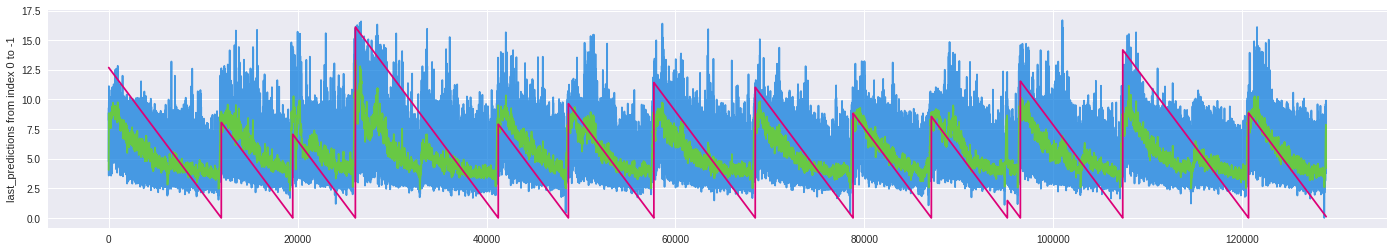

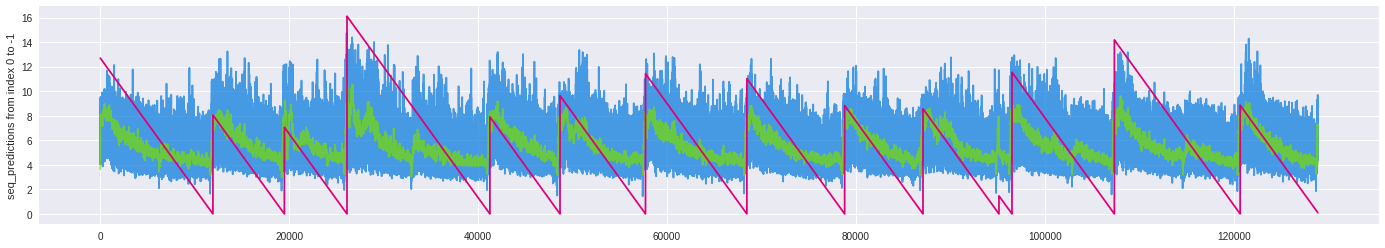

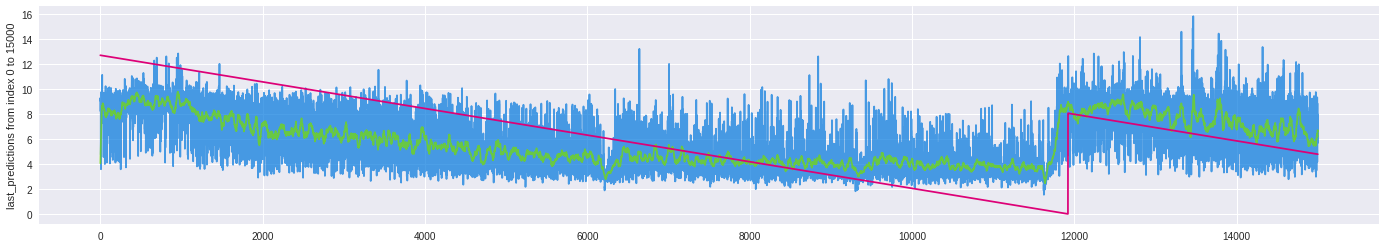

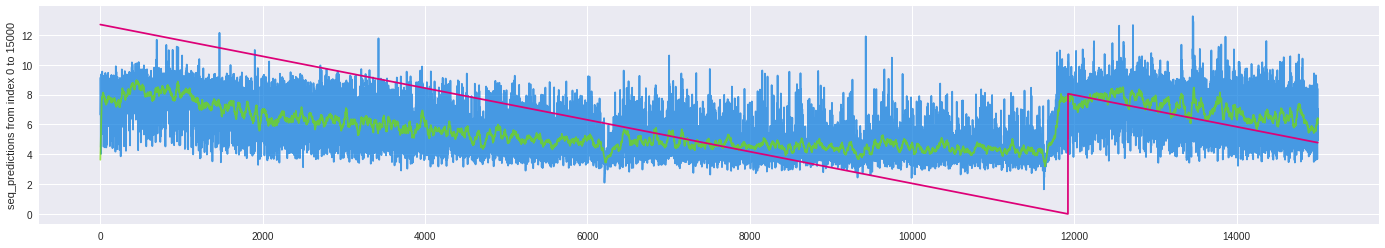

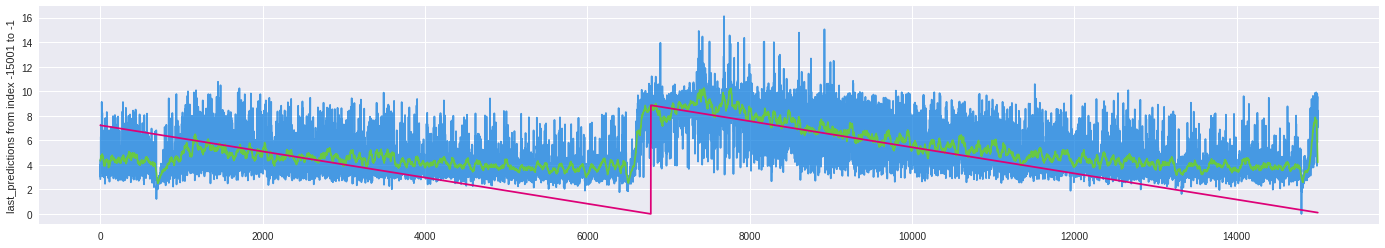

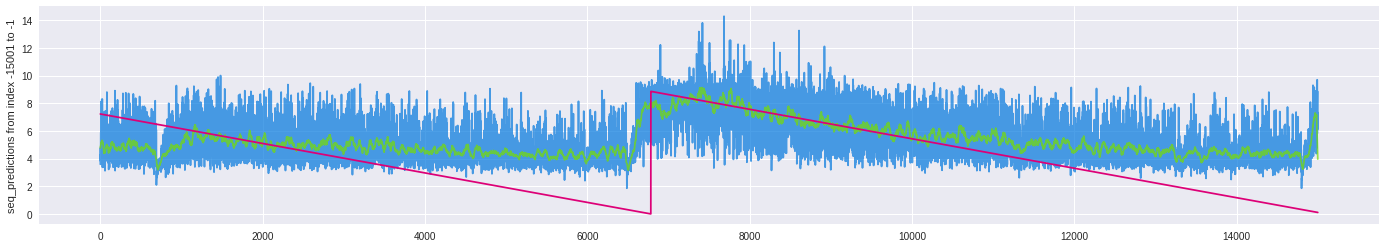

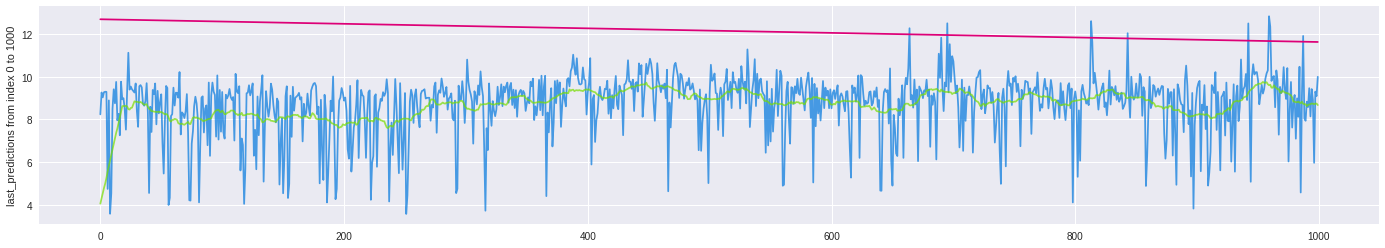

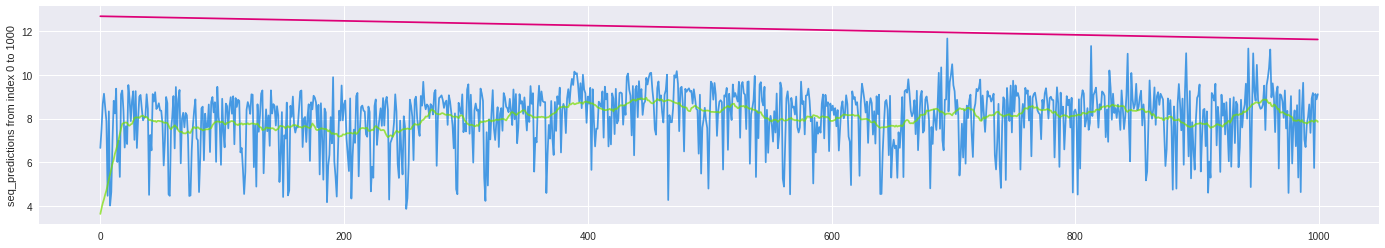

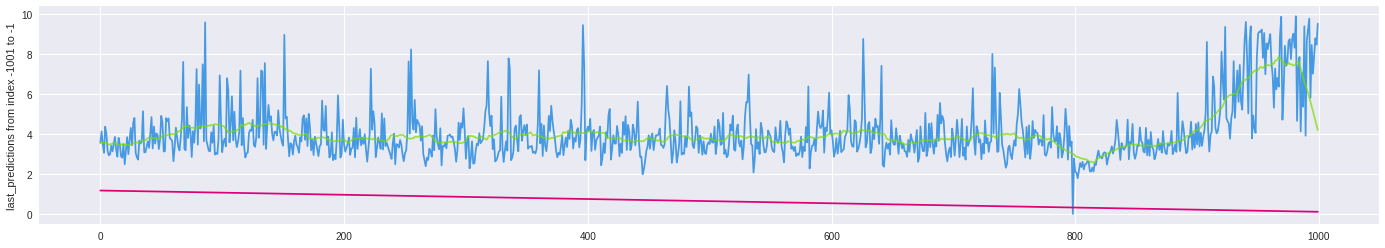

INFO:tensorflow:Using config: {'_model_dir': 'gs://lanl-earthquake-prediction/models/2019-02-09-14-56-23/dcnn-p-e2e-tf/x9_4', '_tf_random_seed': 42, '_save_summary_steps': 1094400, '_save_checkpoints_steps': 1094400, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7faa8bed9828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.82.71.122:8470', '_evaluation_master': 'grpc://10.82.71.122:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=855, num_shards=8,

100%|██████████| 1007/1007 [00:38<00:00, 25.86it/s]


INFO:tensorflow:Calling model_fn.
{'experiment_name': 'x9', 'description': 'experiment 9 - mse ', 'learning_rate': 0.00125, 'dilation_rates': [1, 4, 16, 64, 256, 1024, 1, 4, 16, 64, 256, 1024], 'kernel_sizes': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 'filter_width': 32, 'random_seed': 42, 'max_epochs': 120, 'epochs_per_validation': 10, 'early_stopping_epsilon': 2.0, 'use_last_mae_loss': False, 'padding': 'causal', 'cross_validation_sets': [5, 4, 3, 2, 1, 0, 6], 'reshuffle_training_data': False, 'train_packets': 109508, 'valid_packets': 19487, 'train_tf_record_files': ['gs://lanl-earthquake-prediction/datasets/eq_6_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_7_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_8_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_9_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_10_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_11_packets.tfrecord', 'gs://lanl-earthquake-predicti

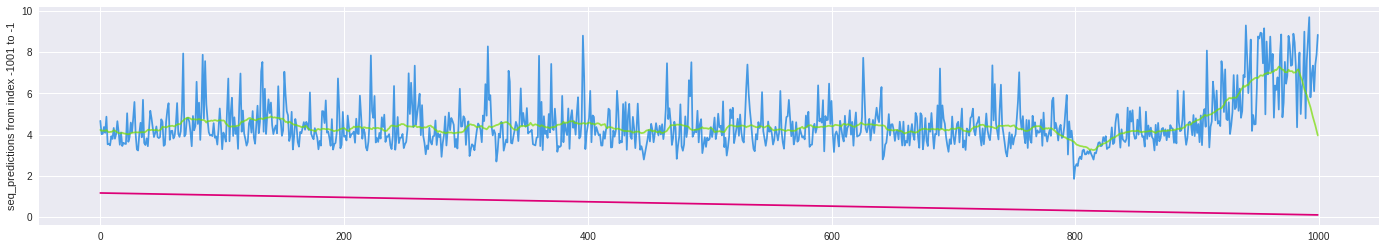

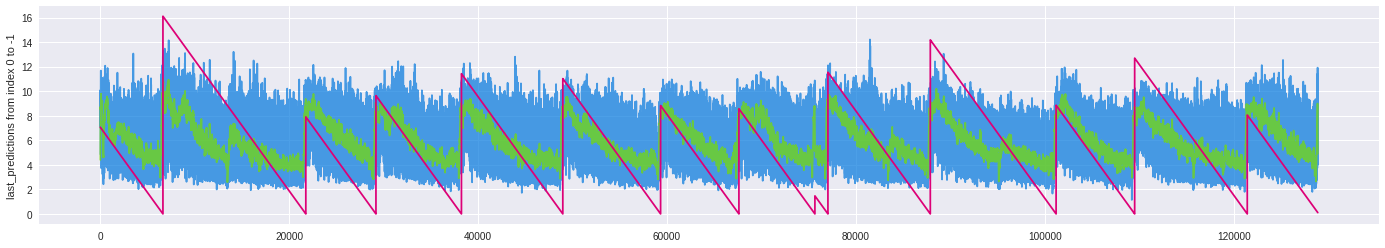

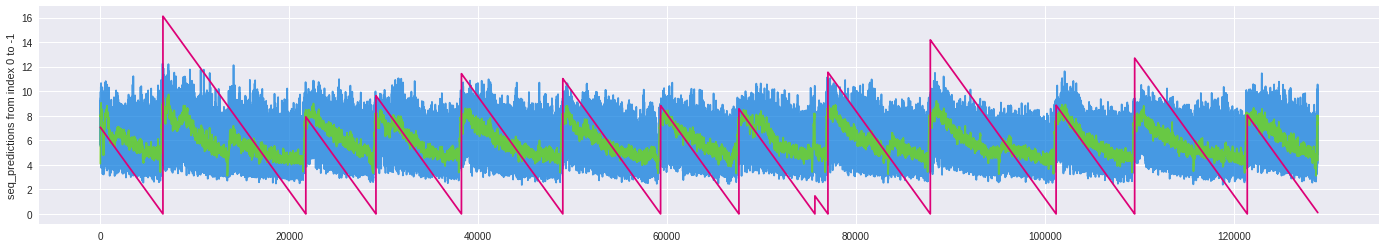

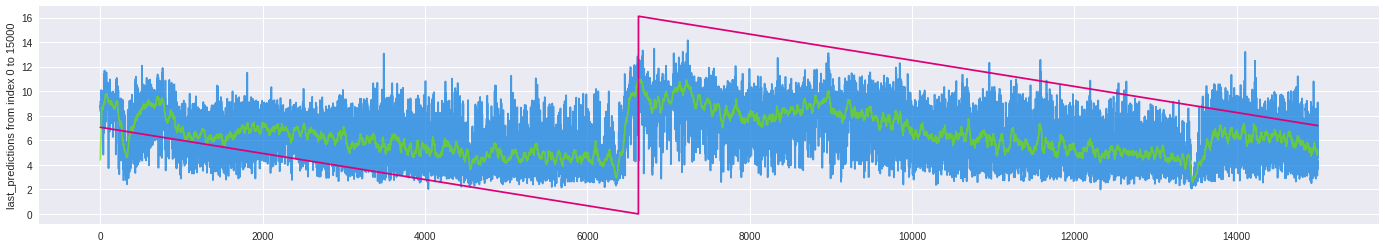

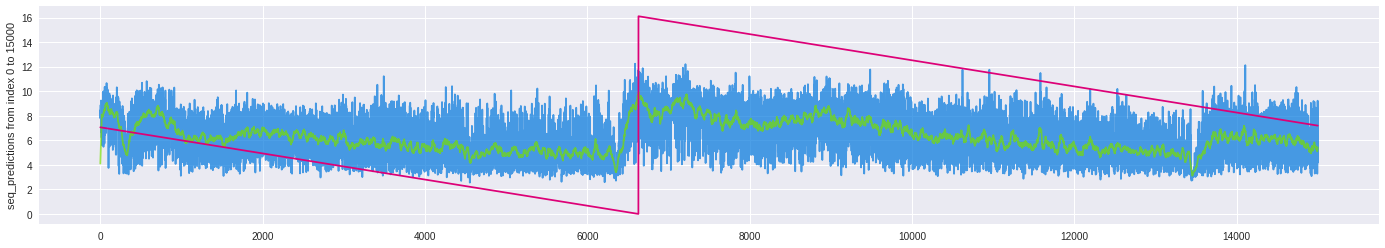

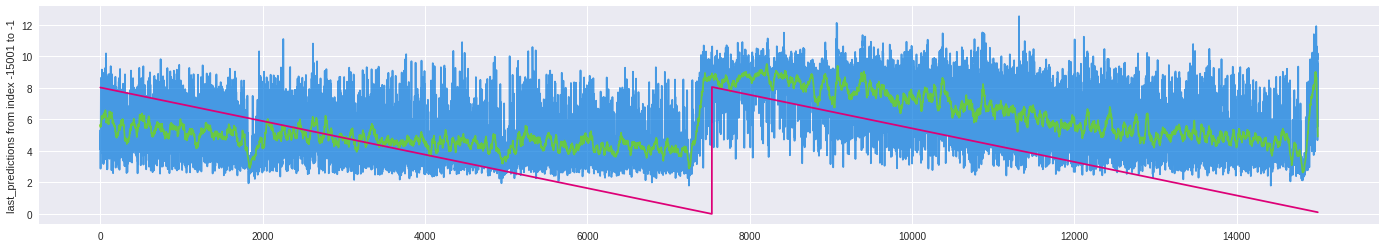

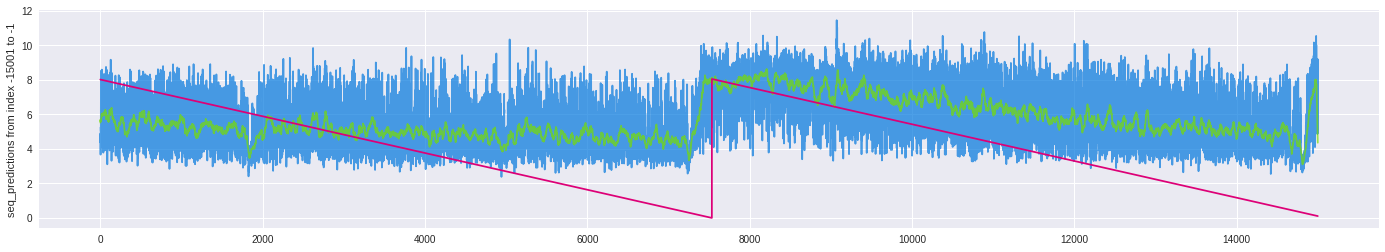

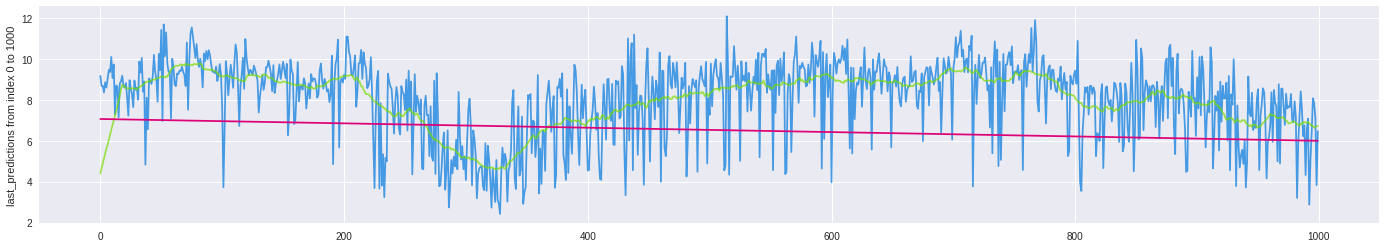

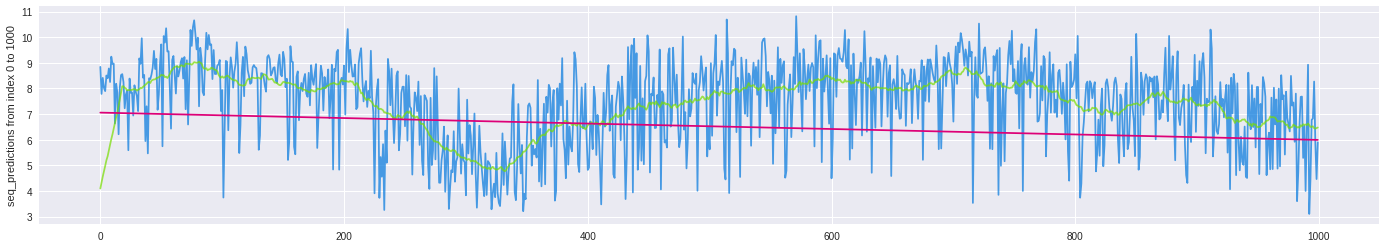

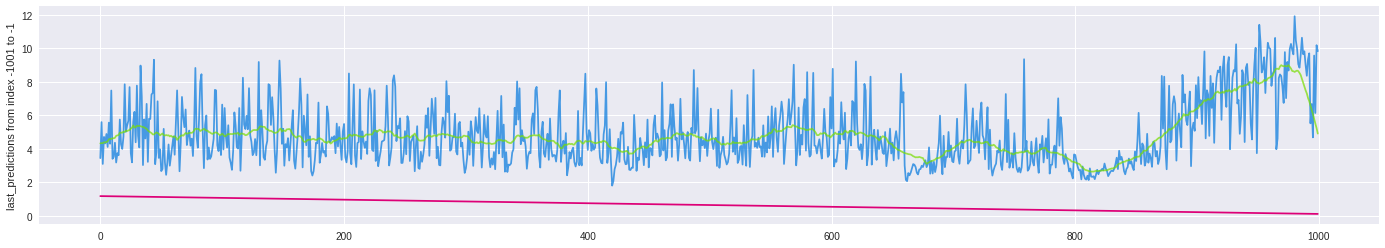

INFO:tensorflow:Using config: {'_model_dir': 'gs://lanl-earthquake-prediction/models/2019-02-09-14-56-23/dcnn-p-e2e-tf/x9_3', '_tf_random_seed': 42, '_save_summary_steps': 1071360, '_save_checkpoints_steps': 1071360, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7faa94c2d400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.82.71.122:8470', '_evaluation_master': 'grpc://10.82.71.122:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=837, num_shards=8,

  0%|          | 0/1006 [00:00<?, ?it/s]

{'experiment_name': 'x9', 'description': 'experiment 9 - mse ', 'learning_rate': 0.00125, 'dilation_rates': [1, 4, 16, 64, 256, 1024, 1, 4, 16, 64, 256, 1024], 'kernel_sizes': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 'filter_width': 32, 'random_seed': 42, 'max_epochs': 120, 'epochs_per_validation': 10, 'early_stopping_epsilon': 2.0, 'use_last_mae_loss': False, 'padding': 'causal', 'cross_validation_sets': [5, 4, 3, 2, 1, 0, 6], 'reshuffle_training_data': False, 'train_packets': 107238, 'valid_packets': 21757, 'train_tf_record_files': ['gs://lanl-earthquake-prediction/datasets/eq_8_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_9_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_10_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_11_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_12_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_13_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_0_packets.tfrecor

100%|██████████| 1006/1006 [00:36<00:00, 36.54it/s]


INFO:tensorflow:Calling model_fn.
{'experiment_name': 'x9', 'description': 'experiment 9 - mse ', 'learning_rate': 0.00125, 'dilation_rates': [1, 4, 16, 64, 256, 1024, 1, 4, 16, 64, 256, 1024], 'kernel_sizes': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 'filter_width': 32, 'random_seed': 42, 'max_epochs': 120, 'epochs_per_validation': 10, 'early_stopping_epsilon': 2.0, 'use_last_mae_loss': False, 'padding': 'causal', 'cross_validation_sets': [5, 4, 3, 2, 1, 0, 6], 'reshuffle_training_data': False, 'train_packets': 107238, 'valid_packets': 21757, 'train_tf_record_files': ['gs://lanl-earthquake-prediction/datasets/eq_8_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_9_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_10_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_11_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_12_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_13_packets.tfrecord', 'gs://lanl-earthquake-predic

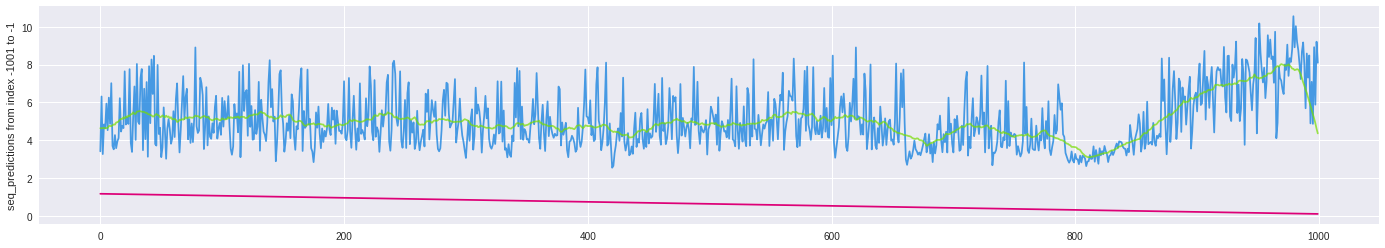

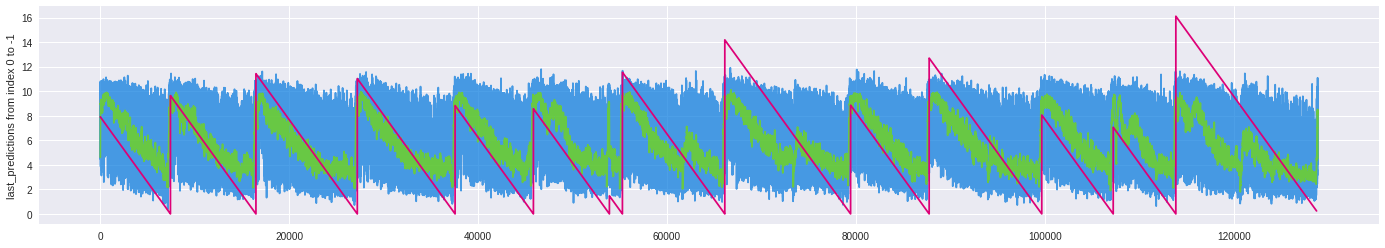

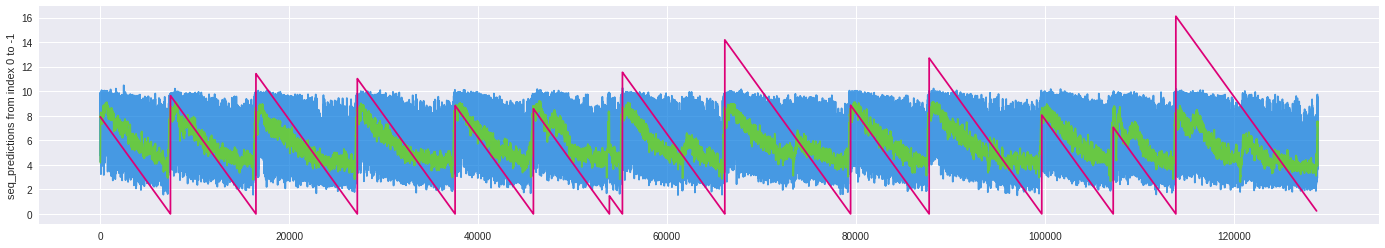

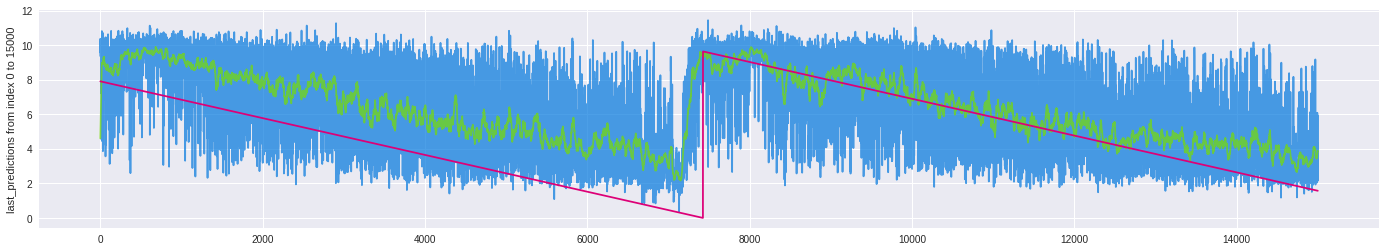

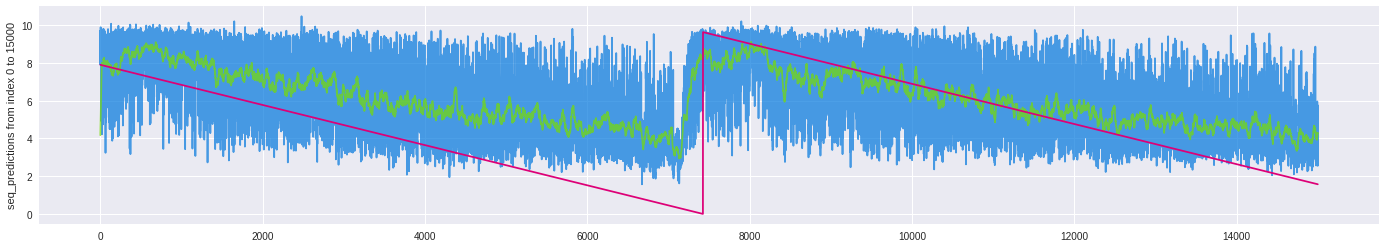

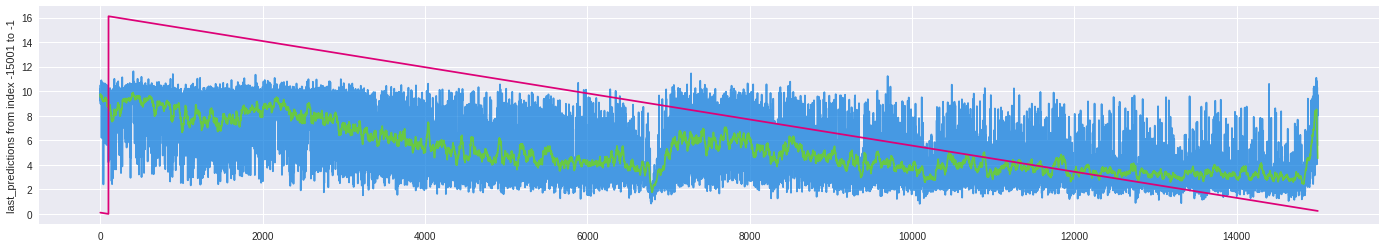

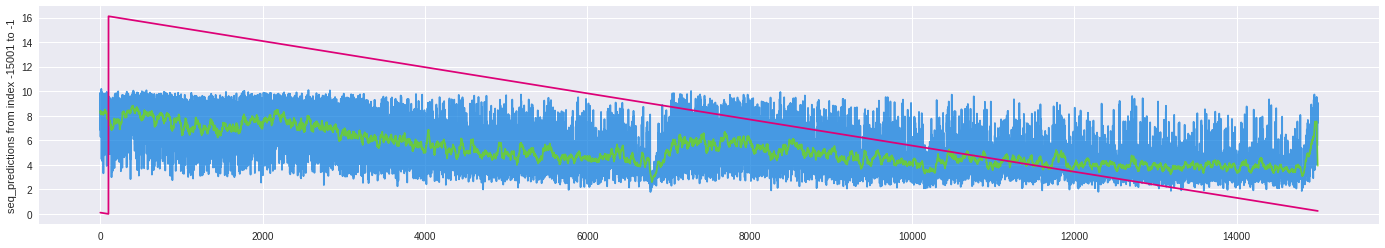

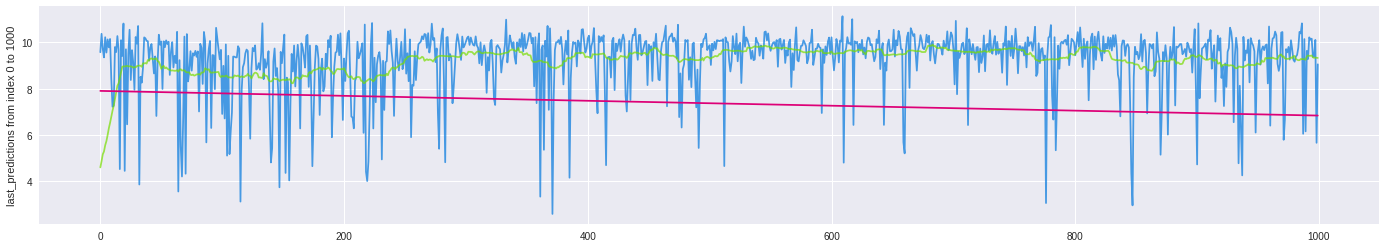

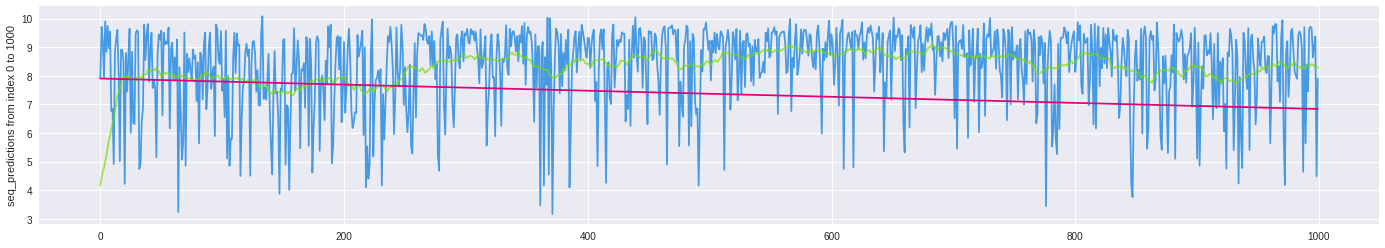

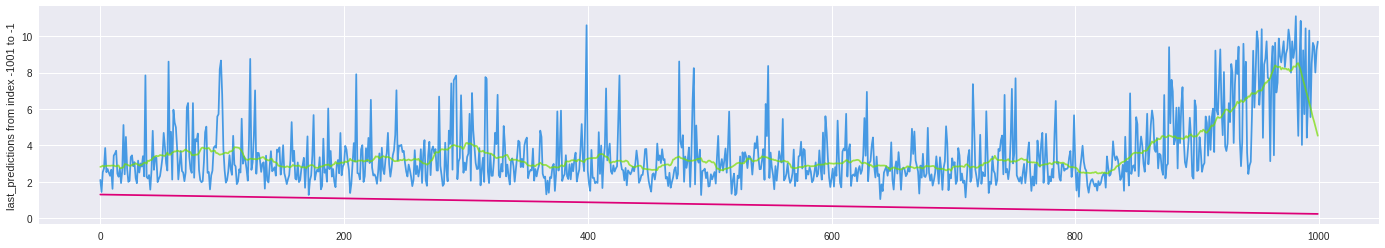

INFO:tensorflow:Using config: {'_model_dir': 'gs://lanl-earthquake-prediction/models/2019-02-09-14-56-23/dcnn-p-e2e-tf/x9_2', '_tf_random_seed': 42, '_save_summary_steps': 1125120, '_save_checkpoints_steps': 1125120, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7faa8e1d1f98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.82.71.122:8470', '_evaluation_master': 'grpc://10.82.71.122:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=879, num_shards=8,

100%|██████████| 1007/1007 [00:38<00:00, 26.47it/s]


INFO:tensorflow:Calling model_fn.
{'experiment_name': 'x9', 'description': 'experiment 9 - mse ', 'learning_rate': 0.00125, 'dilation_rates': [1, 4, 16, 64, 256, 1024, 1, 4, 16, 64, 256, 1024], 'kernel_sizes': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 'filter_width': 32, 'random_seed': 42, 'max_epochs': 120, 'epochs_per_validation': 10, 'early_stopping_epsilon': 2.0, 'use_last_mae_loss': False, 'padding': 'causal', 'cross_validation_sets': [5, 4, 3, 2, 1, 0, 6], 'reshuffle_training_data': False, 'train_packets': 112519, 'valid_packets': 16476, 'train_tf_record_files': ['gs://lanl-earthquake-prediction/datasets/eq_10_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_11_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_12_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_13_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_0_packets.tfrecord', 'gs://lanl-earthquake-prediction/datasets/eq_1_packets.tfrecord', 'gs://lanl-earthquake-predic

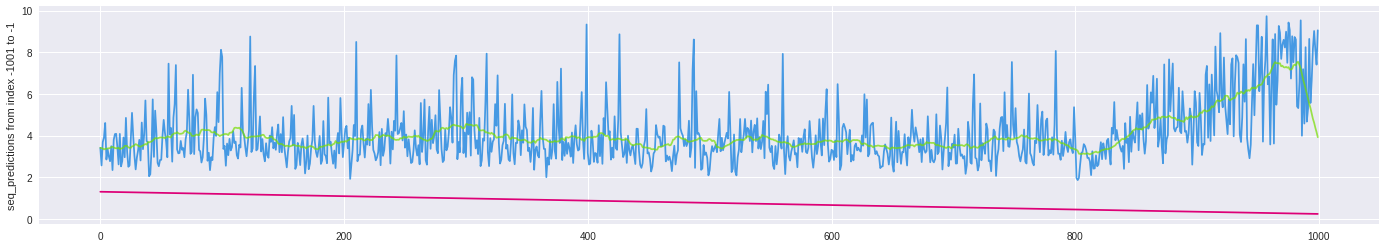

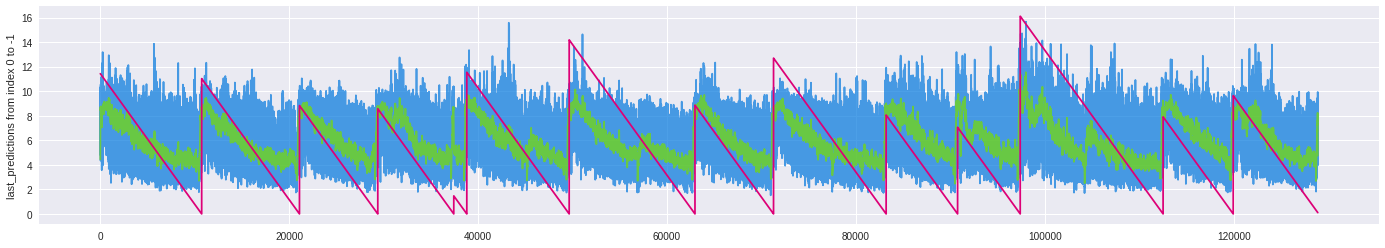

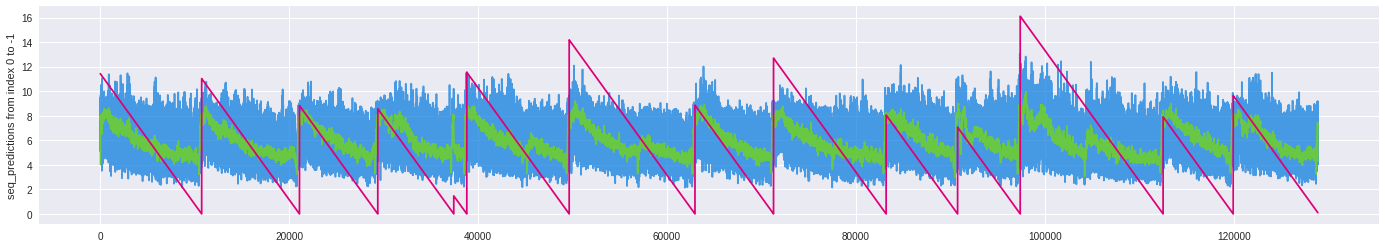

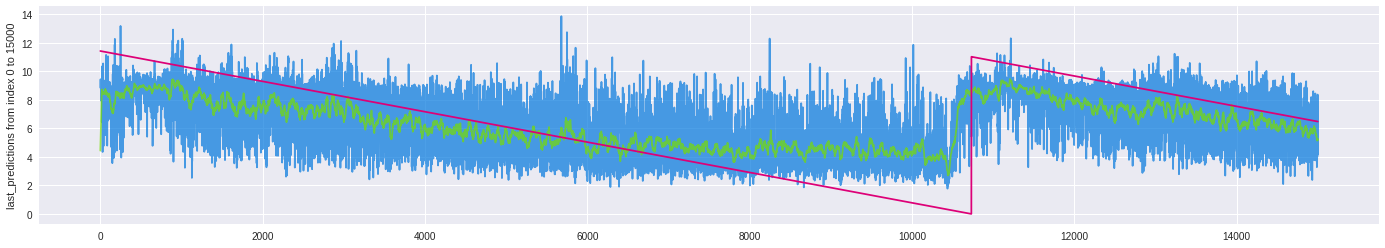

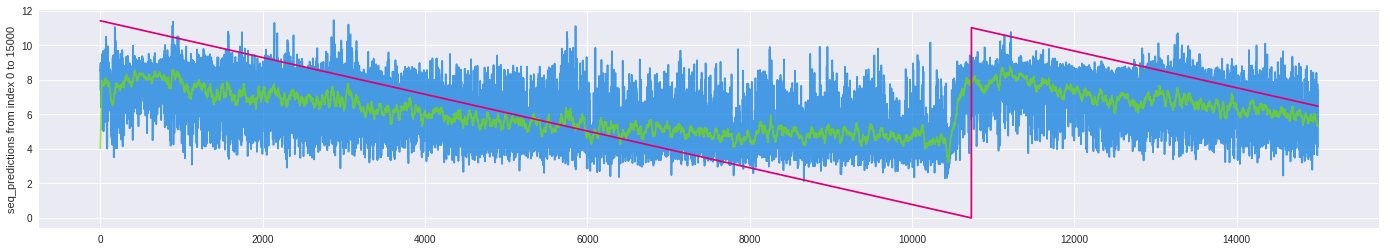

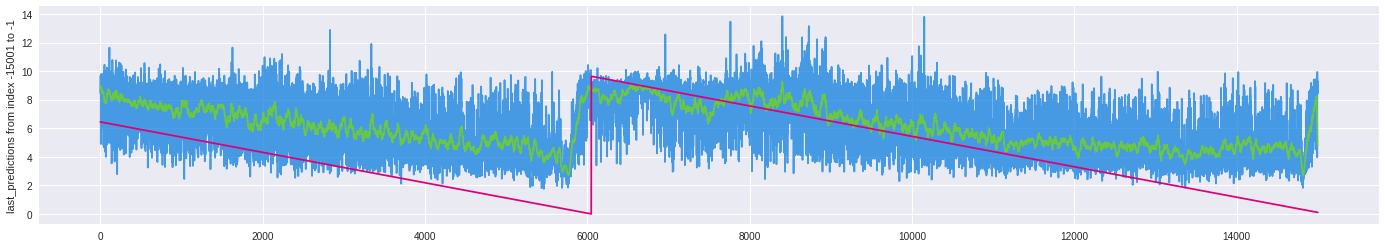

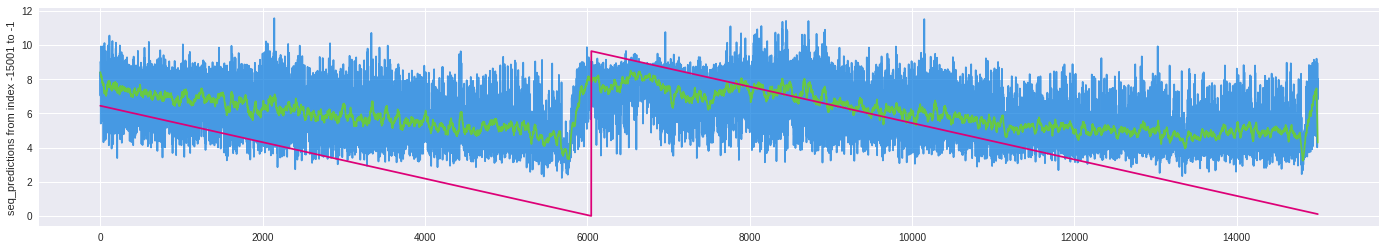

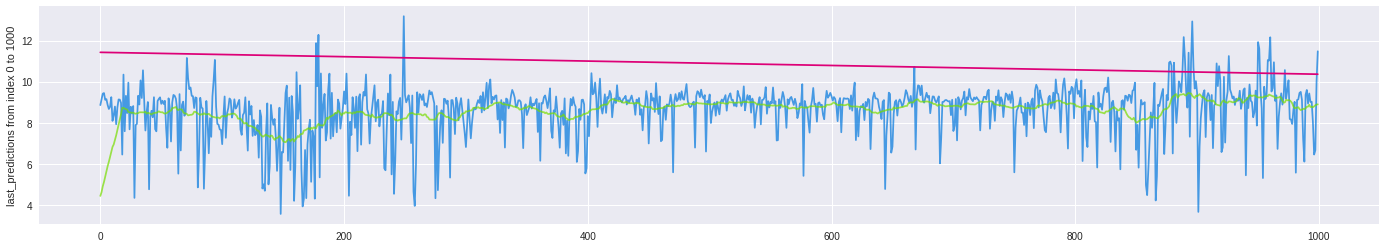

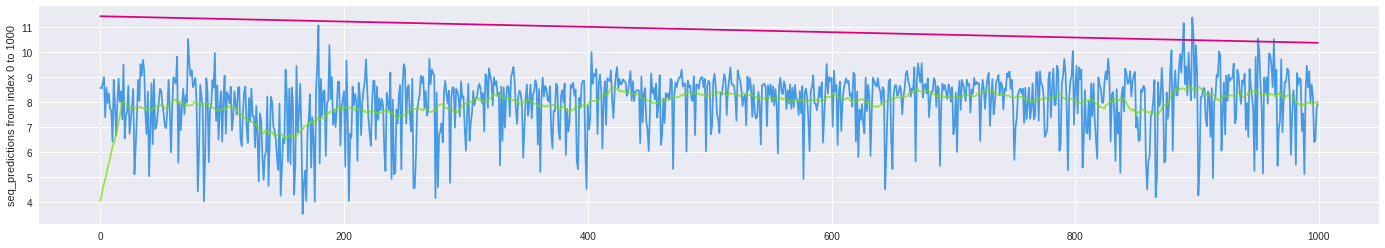

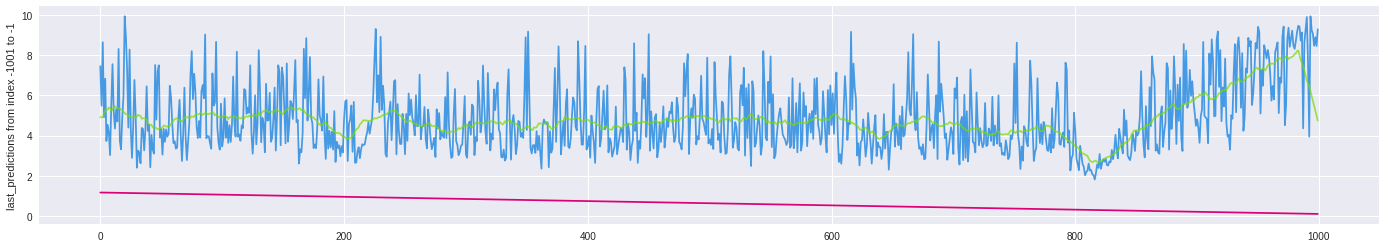

INFO:tensorflow:Using config: {'_model_dir': 'gs://lanl-earthquake-prediction/models/2019-02-09-14-56-23/dcnn-p-e2e-tf/x9_1', '_tf_random_seed': 42, '_save_summary_steps': 1079040, '_save_checkpoints_steps': 1079040, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7faa8d29a2e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.82.71.122:8470', '_evaluation_master': 'grpc://10.82.71.122:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=843, num_shards=8,

In [0]:

for params in experiments:
  max_epochs = params['max_epochs']
  random_seed = params['random_seed']
  epochs_per_validation = params['epochs_per_validation']
  early_stopping_epsilon = params['early_stopping_epsilon']
  experiment_name = params['experiment_name']
  cross_validation_sets = params['cross_validation_sets']
  
  max_cross_validation_steps = (train_earthquakes+valid_earthquakes) // valid_earthquakes
  time_string = time.strftime('%Y-%m-%d-%H-%M-%S')
  tf_record_files = ["{0}eq_{1}_packets.tfrecord".format(DATASET_PATH, i) for i in range(total_earthquakes)]
 
  sendParams(discord_webhook_url, 'Experiment started!', '', True, params)
    
  for cv_step in cross_validation_sets:
    try:
      cv_shift = cv_step * valid_earthquakes
      cv_params = dict(params)
      cv_packets = list(packets[:-test_earthquakes])
      cv_packets = cv_packets[-cv_shift:] + cv_packets[:-cv_shift] # roll
      cv_tf_record_files = list(tf_record_files[:-test_earthquakes])
      cv_tf_record_files = cv_tf_record_files[-cv_shift:] + cv_tf_record_files[:-cv_shift]  # roll

      cv_params['train_packets'] = sum(cv_packets[:train_earthquakes])
      cv_params['valid_packets'] = sum(cv_packets[train_earthquakes:])
      cv_params['train_tf_record_files'] = cv_tf_record_files[:train_earthquakes]
      cv_params['valid_tf_record_files'] = cv_tf_record_files[train_earthquakes:]

      train_batches = cv_params['train_packets'] // train_batch_size
      valid_batches = cv_params['valid_packets'] // valid_batch_size
      cv_params['train_batches'] = train_batches
      cv_params['valid_batches'] = valid_batches

      MODEL_DIR = 'gs://{}/models/{}/{}/{}_{}'.format(bucket, time_string, model_name, experiment_name, cv_step)

      train_steps = epochs_per_validation*train_batches*train_batch_size

      config = tf.contrib.tpu.RunConfig(
          tf_random_seed=random_seed,
          master=TF_MASTER,
          model_dir=MODEL_DIR,
          save_summary_steps=train_steps,
          save_checkpoints_steps=train_steps,
          tpu_config=tf.contrib.tpu.TPUConfig(num_shards=8, iterations_per_loop=train_batches))

      regressor = tf.contrib.tpu.TPUEstimator(
          model_fn=model_fn,
          params=cv_params,
          config=config,
          train_batch_size = train_batch_size,
          eval_batch_size = valid_batch_size,
          predict_batch_size = predict_batch_size,
          eval_on_tpu=use_tpu,
          use_tpu=use_tpu)

      sendParams(discord_webhook_url, 'Training started!', 'experiment: {} cv_step: {}'.format(experiment_name, cv_step), True, cv_params)

      last_last_mae = None
      epoch = 0
      while epoch < max_epochs:
        epoch += epochs_per_validation
        
        # Train the Model.
        eval_result = regressor.train(input_fn=train_fn, steps=epochs_per_validation*train_batches)\
                               .evaluate(input_fn=valid_fn, steps=valid_batches)
        
        discord_message = 'Experiment: {} Epoch: {}'.format(experiment_name, epoch)
        sendParams(discord_webhook_url, 'Validation', discord_message, True, eval_result)
        
        # Early stopping
        if last_last_mae and eval_result['last_mae'] > last_last_mae + early_stopping_epsilon:
          break
        elif last_last_mae:
          last_last_mae = min(eval_result['last_mae'], last_last_mae)
        else:
          last_last_mae = eval_result['last_mae']

      plotPredictions(discord_webhook_url, regressor, cv_params)

    except Exception as e:
      print('Send plot failed!', e)
